In this problem, we implement two naive Bayes classifiers to filter spam emails.  For a prior, assume that spam is equally as likely as not-spam.  

The first classifier is based on a Bernoulli model. The features $z_{nw}$ are whether or not the word $w$ appears in email $n$.  The labels $y_{nk}$ are $1$ iff email $n$ is of class $k$, for $k=0, 1$.  The generative model for the Bernoulli model is,
$$
p (z_n | y_{nk} = 1, \mu ) = \prod_{w} \mu_{kw }^{ z_{nw} } ( 1 - \mu_{kw } )^{ 1 - z_{nw } }.
$$
The second classifer is based on a geometric distribution using the raw word counts $x_{nw}$. The generative model is,
$$
p (x_n | y_{nk} = 1, \theta ) = \prod_{w} \theta_{kw} ( 1  - \theta_{kw} )^{ x_{nw} }
$$
The dataset is in the enron.mat file and contains training, validation and test datasets preprocessed in word-count form. 

<b>1.a)</b>  For the Bernoulli model, implement the thresholded estimator, 
$$
\hat{\mu}_{kw} = \max \left\{ \frac{1}{N_k} \sum_{n=1}^N y_{nk} z_{nw}, \delta \right\}, \qquad N_k = \sum_{n=1}^N y_{nk}. 
$$
Plot validation accuracy for $\delta \in \{ 10^{-3}, 10^{-5}, 10^{-7}, 10^{-9}, 10^{-11} \}$ and report the test accuracy for the model with the highest validation accuracy on the Enron dataset.

In [19]:
import numpy as np
import problem1
import imp
import matplotlib.pyplot as plt
imp.reload(problem1)
from scipy.io import loadmat
data = loadmat('enron.mat')
thresholds = np.power(10.0, [-3, -5, -7, -9, -11])
bernoulliClassifier = problem1.spamClassifier(data, method='Bernoulli')
bernoulliClassifier.validate(thresholds)
print('The threshold with the best validation accuracy is:', bernoulliClassifier.threshold, '\n', 'The test accuracy with this threshold is: '+'{:.4f}'.format(bernoulliClassifier.accuracy(bernoulliClassifier.predict(bernoulliClassifier.zTest), bernoulliClassifier.yTest)))

The threshold with the best validation accuracy is: 1e-07 
 The test accuracy with this threshold is: 0.9890


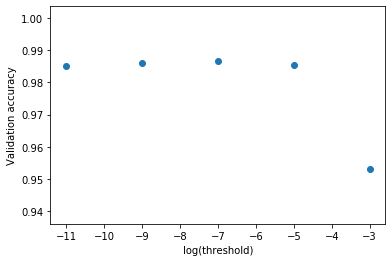

In [20]:
plt.scatter([-3,-5,-7,-9,-11], bernoulliClassifier.acc)
plt.xlabel("log(threshold)")
plt.ylabel("Validation accuracy")
plt.show()

<b>1.b)</b>  Suppose you use an unthresholded estimator, i.e., $\hat{\mu}_{kw}$ with $\delta =0$, corresponding to the MLE. What fraction of spam test documents would be assigned $0$ probability of being spam?  What fraction of not-spam test documents would be assigned $0$ probability of being not-spam?

In [21]:
mu = bernoulliClassifier.mle(bernoulliClassifier.zTrain, bernoulliClassifier.yTrain, 1, 0)
#Find the words that do not appear in any training spam emails:
wordsInNoSpam = np.zeros(mu.shape)
wordsInNoSpam[np.where(mu<0.5 / np.sum(bernoulliClassifier.yTrain))]=1 
#Find how many spam emails in the test training set contain at least one of these words:
m = len(np.where((bernoulliClassifier.zTest.multiply(bernoulliClassifier.yTest)).dot(wordsInNoSpam.transpose())>0.9)[0])
print('The fraction of spam emails that would be assigned probability 0 of being spam in the test data set is '+'{:.3f}'.format(m / np.sum(bernoulliClassifier.yTrain)))
#Repeat for not-spam:
mu = bernoulliClassifier.mle(bernoulliClassifier.zTrain,1- bernoulliClassifier.yTrain, 1, 0)
wordsInNoNotSpam = np.zeros(mu.shape)
wordsInNoNotSpam[np.where(mu<0.5 / np.sum(1-bernoulliClassifier.yTrain))]=1 
m = len(np.where((bernoulliClassifier.zTest.multiply(1-bernoulliClassifier.yTest)).dot(wordsInNoNotSpam.transpose())>0.9)[0])
print('The fraction of not-spam emails that would be assigned probability 0 of being not-spam in the test data set is '+'{:.3f}'.format(m / np.sum(bernoulliClassifier.yTrain)))

The fraction of spam emails that would be assigned probability 0 of being spam in the test data set is 0.195
The fraction of not-spam emails that would be assigned probability 0 of being not-spam in the test data set is 0.150


<b>1c)</b> Using the best model from <b>1a)</b>, calculate the score function $g(w) = \log \mu_{1w} - \log \mu_{0w}$.  List the 10 highest words and lowest words, which are indicative of spam and not-spam emails, respectively.

In [22]:
score = np.log(bernoulliClassifier.mu1 ) - np.log(bernoulliClassifier.mu0)
index = np.argsort(score)
print('The 10 words most indicative of non-spam are:')
for i in range(10):
    print(i+1,'. ', data['vocab'][index[0,i]][0][0])
print('The 10 words most indicative of spam are:')
for i in range(10):
    print(i+1, '.', data['vocab'][index[0, index.shape[1]-i-1]][0][0])


The 10 words most indicative of non-spam are:
1 .  kaminski
2 .  ena
3 .  hourahead
4 .  mmbtu
5 .  westdesk
6 .  variances
7 .  stinson
8 .  enronxgate
9 .  sitara
10 .  ees
The 10 words most indicative of spam are:
1 . viagra
2 . php
3 . ï¿½
4 . cialis
5 . pills
6 . corel
7 . wiil
8 . photoshop
9 . stationery
10 . pharmacy


<b>1d)</b> Consider the geometric model with count data $x$. Using the best Bernoulli classifier $\hat{\mu}$ from <b>1a)</b>, let $\hat{\theta} = 1 - \hat{\mu}$.  What is the test accuracy of this model?

In [23]:
bernoulliClassifier.method = 0
bernoulliClassifier.thetaInv1 = 1/ (1-bernoulliClassifier.mu1 )
bernoulliClassifier.thetaInv0 = 1/ (1 - bernoulliClassifier.mu0)
print('The test accuracy of this model is '+'{:.4f}'.format(bernoulliClassifier.accuracy(bernoulliClassifier.yTest, bernoulliClassifier.predict(bernoulliClassifier.xTest))))

The test accuracy of this model is 0.9864


<b>1e)</b> For the geometric classifier, implement the thresholded estimator,
$$
\hat{\theta}_{kw} = \left[ 1 + \max \left\{ \frac{1}{N_k} \sum_{n=1}^N y_{nk} x_{nw} , \delta \right\} \right]^{-1}, \qquad N_k = \sum_{n=1}^N y_{nk}.
$$
Calculate and plot the validation accuracy for a range of thresholds $\delta \in \{10^{-1}, 10^{-3}, \dots, 10^{-17} \}$.  Report the test accuracy of the model with the best validation performance.

In [24]:
geometricClassifier = problem1.spamClassifier(data, method='Geometric')
thresholds = np.power(10.0, [-1, -3, -5, -7, -9, -11, -13, -15, -17])
geometricClassifier.validate(thresholds)
print('The threshold with the best validation accuracy is:', geometricClassifier.threshold, '\n', 'The test accuracy with this threshold is: '+'{:.4f}'.format(geometricClassifier.accuracy(geometricClassifier.predict(geometricClassifier.xTest), geometricClassifier.yTest)))

The threshold with the best validation accuracy is: 1e-05 
 The test accuracy with this threshold is: 0.9913


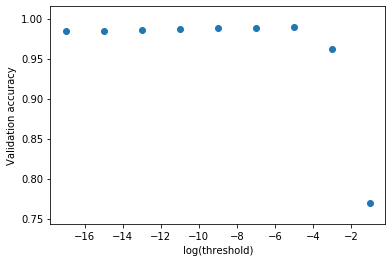

In [25]:
plt.scatter([-1, -3, -5, -7, -9, -11, -13, -15, -17], geometricClassifier.acc)
plt.xlabel("log(threshold)")
plt.ylabel("Validation accuracy")
plt.show()